In [1]:
# HOW TO USE WITH ROCM:
#
# How to get this working with AMD ROCm:
#
# create conda environment with all required libraries
# $ conda create -n env_torch-rocm-24-02-11 ipykernel numpy matplotlib tqdm scipy -c conda-forge -y
#
# activate created conda environment to allow installation of further packages with pip
# $ conda activate env_torch-rocm-24-02-11
#
# install the ROCm versions of torch via pip and the rocm repository
# $ pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm5.7
#
# export the override variable to make torch use this rocm version
# for my 780m chip it does not have a precompiled one but this one has the same instruction set so it works!
# - $ export HSA_OVERRIDE_GFX_VERSION=11.0.0
# (in this script there is an export for this environment variable included so this can be skipped)
#
# start vs code in the project directory
# - $ code .
#
# With vscode jupyter extensions one can now run this script very similar to spyder ide

In [2]:
# Import required libraries

import os
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from scipy.io import loadmat
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

In [3]:
# Configure run

# Set 780M GPU "cuda instruction set" environment variable
HSA_OVERRIDE = "HSA_OVERRIDE_GFX_VERSION"
GFX_VERSION = "11.0.0"
os.environ[HSA_OVERRIDE] = GFX_VERSION
print('\n'.join([
    f'Set environment variable for current python environment:',
    f'{HSA_OVERRIDE}={GFX_VERSION}']))


def set_compute_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


device = set_compute_device()
print(f'Use computing device: {device}')


def configure_run():
    return {
        "epoch_count": 50,
        # since there are classifications of 10 a multiple of that should hopefully always have roughly equal amounts of
        # each classification in a batch size
        "batch_size": 10
    }


config = configure_run()

Set environment variable for current python environment:
HSA_OVERRIDE_GFX_VERSION=11.0.0
Use computing device: cuda


In [4]:
# Data preparations

def load_data():
    data_train = loadmat('train_32x32.mat')
    data_test = loadmat('test_32x32.mat')

    return (data_train, data_test)


def shapeshift_input_data(X: np.ndarray) -> np.ndarray:
    # convert shape: (32, 32, 3, 26032) to: (26032, 32, 32, 3) => (image_number, Y=row, X=column, RGB)
    return np.moveaxis(X, -1, 0)


def fix_labels(y: np.ndarray) -> np.ndarray:
    """
    The SVHN MNIST-like dataset describes the target labels as follows:
    10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
    Leaving the 10 in will result in a possible confusion when the dataset is validated later.
    Thus the 10 is renamed to 0.
    """
    return np.array([0 if yi == 10
                     else yi
                     for yi in y])


def zip_input_target(X: np.ndarray, y: np.ndarray):
    return list(zip(X, y))


# TODO: Can i prepare the data so that each batch consists of a set of each number? -> batch 1: [0, 1, 2, 3, 4, 5, 6, 7,
# 8, 9] in (img, label) of course

In [5]:
# "Advanced" Custom DataLoader - data preparation

def transformer():
    # alias for readability
    tf = torchvision.transforms

    transform = tf.Compose([
        tf.ToTensor()
    ])
    return transform


transform = transformer()


def prepare_data():
    (train, test) = load_data()

    shifted_train_X = shapeshift_input_data(train['X'])
    shifted_test_X = shapeshift_input_data(test['X'])

    fixed_train_y = fix_labels(train['y'].flat)
    fixed_test_y = fix_labels(test['y'].flat)

    print('Digits and their amount in the training dataset:')
    pprint(dict(sorted(Counter(fixed_train_y).items())))

    print('Digits and their amount in the testing dataset:')
    pprint(dict(sorted(Counter(fixed_test_y).items())))

    return ((shifted_train_X, fixed_train_y),
            (shifted_test_X, fixed_test_y))


((train_X, train_y),
 (test_X, test_y)) = prepare_data()


def create_label_index_dict(labels):
    label_index_dict = {
        digit: [index_in_labels
                for index_in_labels, label in enumerate(labels)
                if label == digit]
        for digit in range(10)
    }
    return label_index_dict


class DigitsDataset(Dataset):
    def __init__(self, digit_imgs_X, target_labels_y, transform=None):
        self.digit_imgs_X = digit_imgs_X
        self.target_labels_y = target_labels_y
        self.transform = transform

        self.label_index_dict = create_label_index_dict(self.target_labels_y)
        # holds "pointer" to each labels index advancement
        self.label_index_itaration = [0] * 10

    def __len__(self):
        max_count_of_single_digit = max(
            len(label_indicies)
            for label_indicies in self.label_index_dict.values())
        return max_count_of_single_digit * 10

    def __getitem__(self, index):
        digit = index % 10

        # get current digits index iteration
        index_of_digit_iteration = self.label_index_itaration[digit]

        # advance iterator
        self.label_index_itaration[digit] += 1
        # if iterator advanced out of digit indices arrays bounds reset it to zero
        if self.label_index_itaration[digit] >= len(self.label_index_dict[digit]):
            self.label_index_itaration[digit] = 0

        index_of_digit_in_data = self.label_index_dict[digit][index_of_digit_iteration]

        sample = self.digit_imgs_X[index_of_digit_in_data]
        target = self.target_labels_y[index_of_digit_in_data]

        if self.transform:
            sample = self.transform(sample)

        return sample, target


dataset_train = DigitsDataset(train_X,
                              train_y,
                              transform=transformer())
dataset_test = DigitsDataset(test_X,
                             test_y,
                             transform=transformer())


print(f'Length of train dataset: {dataset_train.__len__()}')
print(f'Length of test dataset: {dataset_test.__len__()}')


_tud = torch.utils.data
loader_train = _tud.DataLoader(dataset_train,
                               batch_size=config["batch_size"],
                               shuffle=False)
loader_test = _tud.DataLoader(dataset_test,
                              batch_size=config["batch_size"],
                              shuffle=False)


#

Digits and their amount in the training dataset:
{0: 4948,
 1: 13861,
 2: 10585,
 3: 8497,
 4: 7458,
 5: 6882,
 6: 5727,
 7: 5595,
 8: 5045,
 9: 4659}
Digits and their amount in the testing dataset:
{0: 1744,
 1: 5099,
 2: 4149,
 3: 2882,
 4: 2523,
 5: 2384,
 6: 1977,
 7: 2019,
 8: 1660,
 9: 1595}
Length of train dataset: 138610
Length of test dataset: 50990


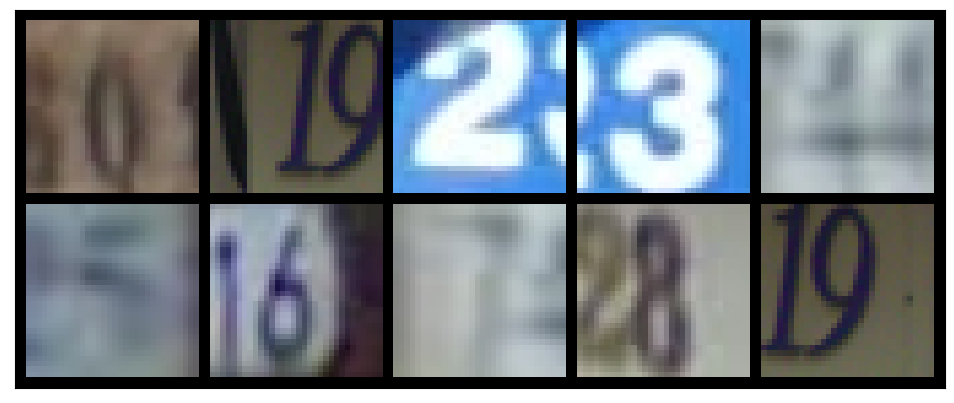

In [6]:
def show_batch(data_loader):
    for images, _ in data_loader:
        _, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(
            make_grid(images[:config["batch_size"]], nrow=5).permute(1, 2, 0))
        break


show_batch(loader_train)

#

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(512, 128)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.1)

        self.fc5 = nn.Linear(128, 32)
        self.act5 = nn.ReLU()
        self.drop5 = nn.Dropout(0.1)

        self.fc6 = nn.Linear(32, 10)
        self.act6 = nn.LogSoftmax()

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 128
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        # input 128, output 32
        x = self.act5(self.fc5(x))
        x = self.drop5(x)
        # input 32, output 10
        x = self.act6(self.fc6(x))
        return x


# create model instance and move it to the GPU
model = CNNModel().to(device)
print(model)

# define loss function
loss_fn = nn.CrossEntropyLoss()
# define optimizer
# uncomment one of the two options
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=8192, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=512, out_features=128, bias=True)
  (act4): ReLU()
  (drop4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=128, out_features=32, bias=True)
  (act5): ReLU()
  (drop5): Dropout(p=0.1, inplace=False)
  (fc6): Linear(in_features=32, out_features=10, bias=True)
  (act6): LogSoftmax(dim=None)
)


In [8]:
# Out of model accuracy

def evaluate(model, validation_loader):
    correct = 0
    total = 0

    # Set the model to evaluation mode
    model.eval()

    # Turn off gradients for evaluation
    with torch.no_grad():

        for images, labels in validation_loader:
            # Move to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            output = model(images)

            # Get the index of the max log-probability
            _, predicted_test = torch.max(output.data,  1)

            total += labels.size(0)
            correct += (predicted_test == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [9]:
# Model training

train_losses = []  # to store training losses
train_accuracy = []  # to store training accuracies
test_accuracy = []  # to store test accuracies

for epoch in range(config["epoch_count"]):
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()

    last_index = 0

    for index, (images, labels) in tqdm(enumerate(loader_train)):

        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        last_index = index

    # Calculate average training loss and accuracy for the epoch
    avg_epoch_loss = epoch_loss / len(loader_train)
    train_losses.append(avg_epoch_loss)

    # In training accuracy
    acc_train_perc = 100 * correct_train / total_train
    train_accuracy.append(acc_train_perc)

    # Out of training accuracy
    acc_test_perc = evaluate(model, loader_test)
    test_accuracy.append(acc_test_perc)

    print('\n'.join([
        '',  # add empty line
        f'Epoch {epoch +1}:',
        f'  Average Training Loss: {avg_epoch_loss:>6.2f}',
        f'  Training Accuracy: {acc_train_perc:>6.2f} %',
        f'  Testing  Accuracy: {acc_test_perc:>6.2f} %']))

0it [00:00, ?it/s]/home/andiman/.conda/envs/env_torch-rocm-24-02-11/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
13861it [01:15, 183.12it/s]



Epoch 1:
  Average Training Loss:   2.30
  Training Accuracy:  10.31 %
  Testing  Accuracy:   9.94 %


13861it [01:14, 187.22it/s]



Epoch 2:
  Average Training Loss:   2.05
  Training Accuracy:  23.48 %
  Testing  Accuracy:  55.22 %


13861it [01:13, 188.70it/s]



Epoch 3:
  Average Training Loss:   1.00
  Training Accuracy:  67.49 %
  Testing  Accuracy:  78.21 %


13861it [01:13, 189.75it/s]



Epoch 4:
  Average Training Loss:   0.55
  Training Accuracy:  82.97 %
  Testing  Accuracy:  85.36 %


13861it [01:13, 189.47it/s]



Epoch 5:
  Average Training Loss:   0.39
  Training Accuracy:  88.04 %
  Testing  Accuracy:  87.12 %


13861it [01:13, 188.66it/s]



Epoch 6:
  Average Training Loss:   0.30
  Training Accuracy:  90.84 %
  Testing  Accuracy:  88.42 %


13861it [01:14, 185.51it/s]



Epoch 7:
  Average Training Loss:   0.24
  Training Accuracy:  92.65 %
  Testing  Accuracy:  88.74 %


13861it [01:14, 185.93it/s]



Epoch 8:
  Average Training Loss:   0.20
  Training Accuracy:  94.02 %
  Testing  Accuracy:  89.14 %


13861it [01:17, 178.61it/s]



Epoch 9:
  Average Training Loss:   0.16
  Training Accuracy:  94.98 %
  Testing  Accuracy:  89.51 %


13861it [01:22, 168.36it/s]



Epoch 10:
  Average Training Loss:   0.14
  Training Accuracy:  95.78 %
  Testing  Accuracy:  89.34 %


13861it [01:10, 195.23it/s]



Epoch 11:
  Average Training Loss:   0.12
  Training Accuracy:  96.36 %
  Testing  Accuracy:  89.52 %


13861it [01:09, 198.57it/s]



Epoch 12:
  Average Training Loss:   0.10
  Training Accuracy:  96.88 %
  Testing  Accuracy:  89.50 %


13861it [01:08, 201.58it/s]



Epoch 13:
  Average Training Loss:   0.09
  Training Accuracy:  97.21 %
  Testing  Accuracy:  89.78 %


13861it [01:08, 201.10it/s]



Epoch 14:
  Average Training Loss:   0.08
  Training Accuracy:  97.52 %
  Testing  Accuracy:  89.50 %


13861it [01:08, 201.52it/s]



Epoch 15:
  Average Training Loss:   0.07
  Training Accuracy:  97.74 %
  Testing  Accuracy:  89.25 %


13861it [01:08, 202.07it/s]



Epoch 16:
  Average Training Loss:   0.06
  Training Accuracy:  98.03 %
  Testing  Accuracy:  89.70 %


13861it [01:08, 201.02it/s]



Epoch 17:
  Average Training Loss:   0.05
  Training Accuracy:  98.28 %
  Testing  Accuracy:  89.84 %


13861it [01:09, 198.20it/s]



Epoch 18:
  Average Training Loss:   0.05
  Training Accuracy:  98.39 %
  Testing  Accuracy:  89.85 %


13861it [01:11, 193.55it/s]



Epoch 19:
  Average Training Loss:   0.05
  Training Accuracy:  98.55 %
  Testing  Accuracy:  89.81 %


13861it [01:09, 199.77it/s]



Epoch 20:
  Average Training Loss:   0.04
  Training Accuracy:  98.65 %
  Testing  Accuracy:  89.52 %


13861it [01:08, 201.78it/s]



Epoch 21:
  Average Training Loss:   0.04
  Training Accuracy:  98.71 %
  Testing  Accuracy:  89.68 %


13861it [01:08, 201.96it/s]



Epoch 22:
  Average Training Loss:   0.04
  Training Accuracy:  98.80 %
  Testing  Accuracy:  88.89 %


13861it [01:08, 201.37it/s]



Epoch 23:
  Average Training Loss:   0.03
  Training Accuracy:  98.94 %
  Testing  Accuracy:  89.73 %


13861it [01:08, 201.88it/s]



Epoch 24:
  Average Training Loss:   0.03
  Training Accuracy:  98.95 %
  Testing  Accuracy:  89.88 %


13861it [01:08, 201.41it/s]



Epoch 25:
  Average Training Loss:   0.03
  Training Accuracy:  99.07 %
  Testing  Accuracy:  89.79 %


13861it [01:08, 201.07it/s]



Epoch 26:
  Average Training Loss:   0.03
  Training Accuracy:  99.12 %
  Testing  Accuracy:  88.50 %


13861it [01:08, 202.01it/s]



Epoch 27:
  Average Training Loss:   0.03
  Training Accuracy:  99.16 %
  Testing  Accuracy:  89.51 %


13861it [01:08, 201.38it/s]



Epoch 28:
  Average Training Loss:   0.02
  Training Accuracy:  99.25 %
  Testing  Accuracy:  89.97 %


13861it [01:08, 201.84it/s]



Epoch 29:
  Average Training Loss:   0.02
  Training Accuracy:  99.27 %
  Testing  Accuracy:  89.73 %


13861it [01:08, 201.60it/s]



Epoch 30:
  Average Training Loss:   0.02
  Training Accuracy:  99.25 %
  Testing  Accuracy:  89.82 %


13861it [01:08, 201.59it/s]



Epoch 31:
  Average Training Loss:   0.02
  Training Accuracy:  99.34 %
  Testing  Accuracy:  89.65 %


13861it [01:08, 202.06it/s]



Epoch 32:
  Average Training Loss:   0.02
  Training Accuracy:  99.39 %
  Testing  Accuracy:  90.00 %


13861it [01:08, 201.68it/s]



Epoch 33:
  Average Training Loss:   0.02
  Training Accuracy:  99.41 %
  Testing  Accuracy:  90.09 %


13861it [01:09, 200.83it/s]



Epoch 34:
  Average Training Loss:   0.02
  Training Accuracy:  99.40 %
  Testing  Accuracy:  89.79 %


13861it [01:08, 201.60it/s]



Epoch 35:
  Average Training Loss:   0.02
  Training Accuracy:  99.51 %
  Testing  Accuracy:  89.75 %


13861it [01:08, 201.38it/s]



Epoch 36:
  Average Training Loss:   0.02
  Training Accuracy:  99.48 %
  Testing  Accuracy:  89.96 %


13861it [01:08, 201.75it/s]



Epoch 37:
  Average Training Loss:   0.02
  Training Accuracy:  99.48 %
  Testing  Accuracy:  90.03 %


13861it [01:09, 200.66it/s]



Epoch 38:
  Average Training Loss:   0.02
  Training Accuracy:  99.48 %
  Testing  Accuracy:  89.74 %


13861it [01:09, 200.69it/s]



Epoch 39:
  Average Training Loss:   0.02
  Training Accuracy:  99.47 %
  Testing  Accuracy:  89.71 %


13861it [01:08, 201.87it/s]



Epoch 40:
  Average Training Loss:   0.01
  Training Accuracy:  99.54 %
  Testing  Accuracy:  89.88 %


13861it [01:08, 201.44it/s]



Epoch 41:
  Average Training Loss:   0.01
  Training Accuracy:  99.55 %
  Testing  Accuracy:  90.35 %


13861it [01:09, 199.71it/s]



Epoch 42:
  Average Training Loss:   0.01
  Training Accuracy:  99.57 %
  Testing  Accuracy:  90.35 %


13861it [01:08, 201.57it/s]



Epoch 43:
  Average Training Loss:   0.01
  Training Accuracy:  99.56 %
  Testing  Accuracy:  89.94 %


13861it [01:08, 201.33it/s]



Epoch 44:
  Average Training Loss:   0.01
  Training Accuracy:  99.59 %
  Testing  Accuracy:  90.29 %


13861it [01:08, 200.92it/s]



Epoch 45:
  Average Training Loss:   0.02
  Training Accuracy:  99.53 %
  Testing  Accuracy:  90.17 %


13861it [01:08, 201.06it/s]



Epoch 46:
  Average Training Loss:   0.01
  Training Accuracy:  99.61 %
  Testing  Accuracy:  89.99 %


13861it [01:09, 199.58it/s]



Epoch 47:
  Average Training Loss:   0.01
  Training Accuracy:  99.63 %
  Testing  Accuracy:  89.96 %


13861it [01:08, 201.45it/s]



Epoch 48:
  Average Training Loss:   0.01
  Training Accuracy:  99.63 %
  Testing  Accuracy:  90.18 %


13861it [01:08, 201.18it/s]



Epoch 49:
  Average Training Loss:   0.01
  Training Accuracy:  99.64 %
  Testing  Accuracy:  90.26 %


13861it [01:09, 200.52it/s]



Epoch 50:
  Average Training Loss:   0.01
  Training Accuracy:  99.66 %
  Testing  Accuracy:  90.16 %


In [10]:
# Model testing (as separate step)


correct_test = 0
total_test = 0

model.eval()

with torch.no_grad():
    for images, labels in loader_test:
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get the index of the max log-probability
        _, predicted_test = torch.max(outputs.data, 1)

        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

# Calculate test accuracy
acc_test_perc = 100 * correct_test / total_test
test_accuracy.append(acc_test_perc)

print(f'Test Accuracy: {acc_test_perc:.2f} %')

Test Accuracy: 90.12 %


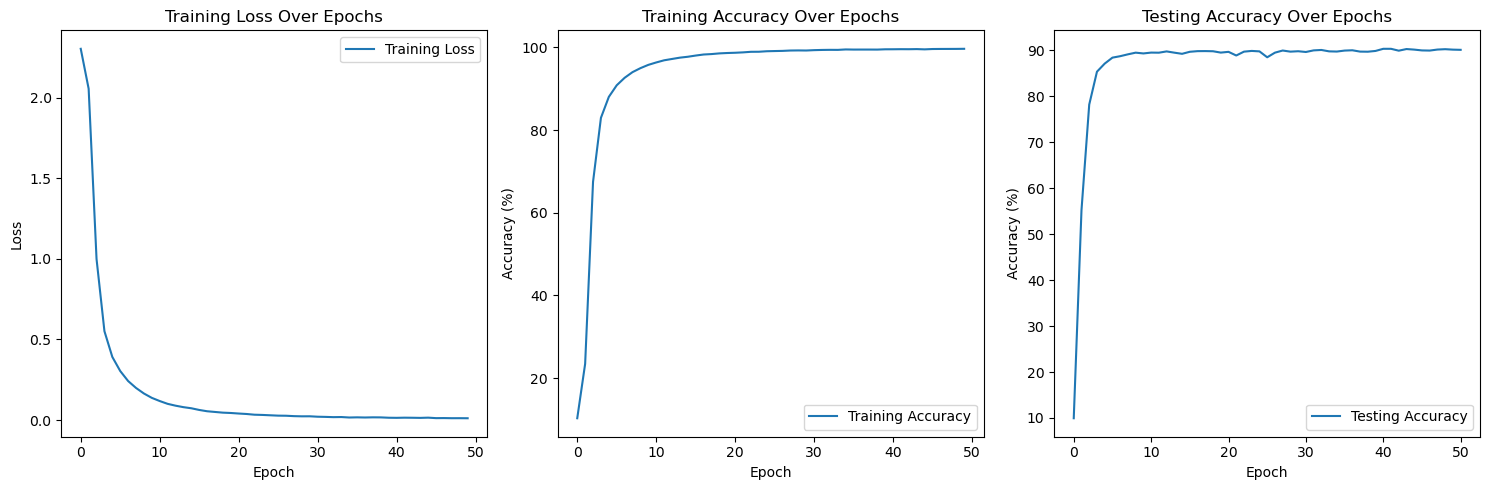

In [11]:
# Visualize training history

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

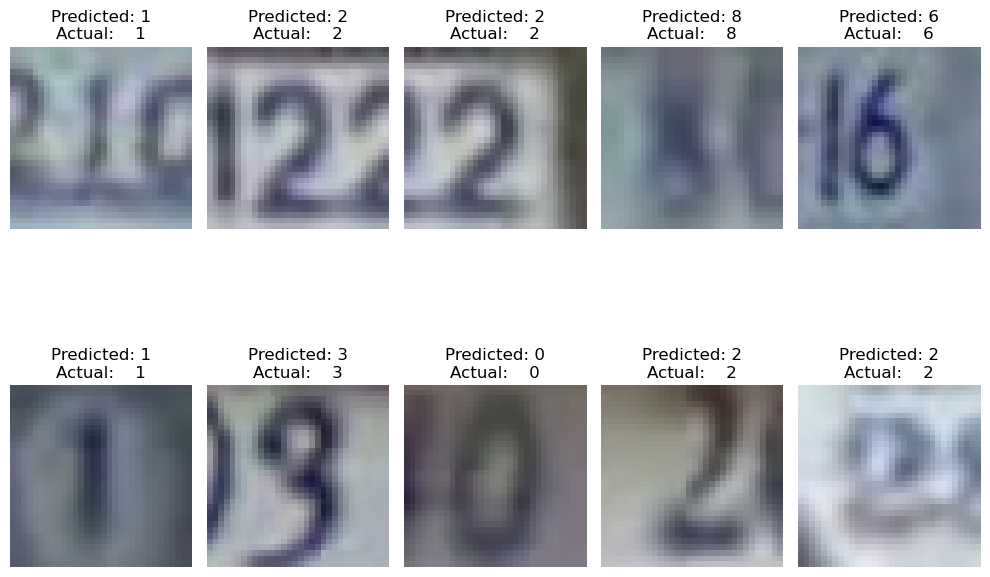

In [12]:
# Visualize prediction

# Create a DataLoader for random sampling from the test dataset
random_testloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=config["batch_size"], shuffle=True
)

# Visualize predictions for batch-size random images
model.eval()
with torch.no_grad():
    images, labels = next(iter(random_testloader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(config["batch_size"], 8))
    for i in range(config["batch_size"]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())
        plt.title('\n'.join([
            f'Predicted: {predicted[i].item()}',
            f'Actual:    {labels[i].item()}'
        ]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()